In [28]:
# Bibliothèques importantes pour l'analyse des séries temporelles
import numpy as np                   # Pour les calculs numériques et la génération de données
import pandas as pd                  # Pour manipuler les données sous forme de tableaux (DataFrame)
import matplotlib.pyplot as plt      # Pour tracer des graphiques et visualiser les séries temporelles
from statsmodels.tsa.seasonal import seasonal_decompose  # Pour décomposer automatiquement la série en tendance, saisonnalité et bruit


In [29]:
df = pd.read_csv("3_1_Electric_Production.csv", sep=";")

In [30]:
df.head()

,DATE,IPG2211A2N
0,01/01/1985,"72,5052"
1,01/02/1985,"70,672"
2,01/03/1985,"62,4502"
3,01/04/1985,"57,4714"
4,01/05/1985,"55,3151"


In [31]:
df.describe()

,DATE,IPG2211A2N
count,397,397
unique,397,397
top,01/01/1985,"72,5052"
freq,1,1


In [32]:
df.isnull().sum()

DATE          0
IPG2211A2N    0
dtype: int64

In [33]:
# Ensure numeric values: replace comma decimals and coerce to float
df['IPG2211A2N'] = df['IPG2211A2N'].astype(str).str.replace(',','.', regex=False)
df['IPG2211A2N'] = pd.to_numeric(df['IPG2211A2N'], errors='coerce')
n_missing = df['IPG2211A2N'].isna().sum()
if n_missing > 0:
    print(f"{n_missing} non-numeric values converted to NaN and will be dropped")
    df = df.dropna(subset=['IPG2211A2N']).reset_index(drop=True)
# Décomposition automatique
decomposition = seasonal_decompose(df['IPG2211A2N'], model='additive', period=52)
df['Tendance'] = decomposition.trend
df['Saisonnalité'] = decomposition.seasonal
df['Bruit'] = decomposition.resid

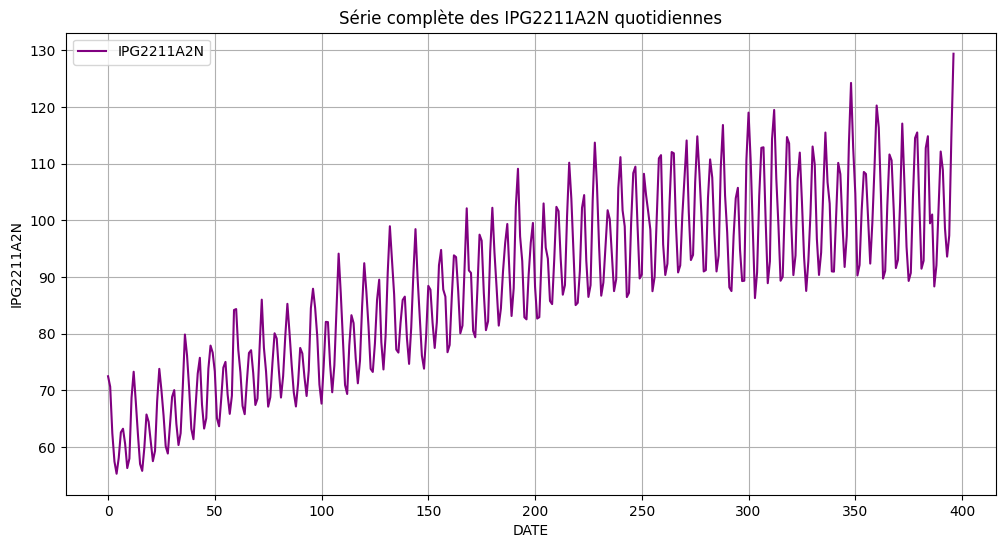

In [34]:
plt.figure(figsize=(12,6))
plt.plot(df.index, df['IPG2211A2N'], color='purple', label='IPG2211A2N')
plt.title("Série complète des IPG2211A2N quotidiennes")
plt.xlabel("DATE")
plt.ylabel("IPG2211A2N")
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
from statsmodels.tsa.stattools import adfuller
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#JE SELECTIONNE LA COLONNE
col = 'IPG2211A2N'
s = df[col].astype(str).str.replace(',','.', regex=False)
s = pd.to_numeric(s, errors='coerce').dropna().reset_index(drop=True)#convertit en valeurs numériques, si une valeur est invalide, elle devient NaN, on supprime les NaN

def adf_p(s):
    res = adfuller(s, autolag='AIC') 
    #fonction qui réalise le test ADF (Augmented Dickey-Fuller) pour vérifier la stationnarité
    return res

# Test initial
res0 = adf_p(s)
p0 = res0[1]
print(f'ADF initial p-value = {p0:.5f}')
series_stationary = s.copy()
applied = 'none'
# store candidate transformed series for testing
candidate = series_stationary
if p0 >= 0.05:
    # 1) Log si toutes les valeurs > 0
    if (series_stationary > 0).all():
        cand = np.log(series_stationary)
        p_cand = adf_p(cand)[1]
        print(f'After log transform ADF p-value = {p_cand:.5f}')
        if p_cand < 0.05:
            series_stationary = cand
            applied = 'log'
    # 2) Différence première (if still non-stationary)
    if applied == 'none':
        cand = series_stationary.diff().dropna()
        p_cand = adf_p(cand)[1]
        print(f'After 1st difference ADF p-value = {p_cand:.5f}')
        if p_cand < 0.05:
            series_stationary = cand
            applied = 'diff1'
    # 3) Différence saisonnière (ex: saison=52 ou 365)
    if applied == 'none':
        saison = 52  # ajustez si besoin (ex: 365)
        cand = series_stationary.diff(saison).dropna()
        p_cand = adf_p(cand)[1]
        print(f'After seasonal diff (period={saison}) ADF p-value = {p_cand:.5f}')
        if p_cand < 0.05:
            series_stationary = cand
            applied = f'seasonal_diff_{saison}'
    # 4) Second difference as last resort
    if applied == 'none':
        cand = series_stationary.diff().dropna()
        cand2 = cand.diff().dropna()
        p_cand2 = adf_p(cand2)[1] if len(cand2) > 0 else 1.0
        print(f'After 2nd difference ADF p-value = {p_cand2:.5f}')
        if p_cand2 < 0.05:
            series_stationary = cand2
            applied = 'diff2'
else:
    print('Series is stationary (initial p < 0.05)')

res_final = adf_p(series_stationary)
p_final = res_final[1]
print(f'Final ADF p-value = {p_final:.5f} (transformation: {applied})')



ADF initial p-value = 0.18621
After log transform ADF p-value = 0.02337
Final ADF p-value = 0.02337 (transformation: log)


Prétraitement : remplace les virgules par des points, convertit la colonne choisie en numérique et supprime les NaN.

Test initial : ADF exécuté et p-value affichée.

Transformations testées (dans cet ordre) :
- Logarithme (si toutes les valeurs > 0).

1ᵉʳ différenciel (différence d’ordre 1).
Différence saisonnière avec période = 52 (ajustable).

2ᵉ différenciel (dernier recours).
Ce qui est enregistré/affiché :
la variable applied indique la transformation effectivement appliquée ('none', 'log', 'diff1', 'seasonal_diff_52', 'diff2'),

series_stationary contient la série transformée finale,
la p-value finale ADF est imprimée (ex. : "Final ADF p-value = ... (transformation: diff1)").

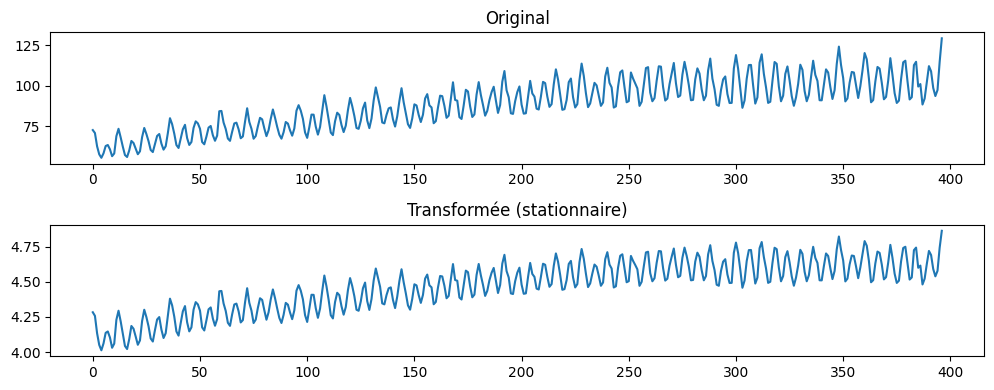

In [36]:
# Visualisation
plt.figure(figsize=(10,4))
plt.subplot(2,1,1); plt.plot(s); plt.title('Original')
plt.subplot(2,1,2); plt.plot(series_stationary); plt.title('Transformée (stationnaire)')
plt.tight_layout(); plt.show()

In [40]:
# Comparaison statistiques
import numpy as np
orig_stats = {'mean': np.nanmean(s), 'std': np.nanstd(s)}
stat_stats = {'mean': np.nanmean(series_stationary), 'std': np.nanstd(series_stationary)}
print('Original mean/std:', orig_stats['mean'], orig_stats['std'])
print('Stationary mean/std:', stat_stats['mean'], stat_stats['std'])



Original mean/std: 88.84721763224182 15.368441302061287
Stationary mean/std: 0.14368585858585856 7.754673482751736


In [38]:
from statsmodels.tsa.stattools import adfuller
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Sélection de la colonne
col = 'IPG2211A2N'
s = df[col].astype(str).str.replace(',', '.', regex=False)
s = pd.to_numeric(s, errors='coerce').dropna().reset_index(drop=True)

def adf_test(series):
    result = adfuller(series, autolag='AIC')
    return result[1]  # p-value

# Test ADF initial
p0 = adf_test(s)
print(f"ADF initial p-value = {p0:.5f}")

series_stationary = s.copy()
applied = 'none'

# Si la série n'est pas stationnaire
if p0 >= 0.05:

    # 1️ Différenciation première
    diff1 = series_stationary.diff().dropna()
    p1 = adf_test(diff1)
    print(f"After 1st difference ADF p-value = {p1:.5f}")

    if p1 < 0.05:
        series_stationary = diff1
        applied = 'diff1'

    # 2Différenciation saisonnière
    if applied == 'none':
        saison = 12  # à adapter (12 mensuel, 52 hebdo, 365 journalier)
        diff_seasonal = series_stationary.diff(saison).dropna()
        p_seasonal = adf_test(diff_seasonal)
        print(f"After seasonal diff (period={saison}) ADF p-value = {p_seasonal:.5f}")

        if p_seasonal < 0.05:
            series_stationary = diff_seasonal
            applied = f'seasonal_diff_{saison}'

    # 3 Différenciation d'ordre 2
    if applied == 'none':
        diff2 = series_stationary.diff().dropna()
        p2 = adf_test(diff2)
        print(f"After 2nd difference ADF p-value = {p2:.5f}")

        if p2 < 0.05:
            series_stationary = diff2
            applied = 'diff2'

else:
    print("Series is already stationary (initial p < 0.05)")

# Résultat final
p_final = adf_test(series_stationary)
print(f"\nFinal ADF p-value = {p_final:.5f}")
print(f"Transformation applied: {applied}")


ADF initial p-value = 0.18621
After 1st difference ADF p-value = 0.00000

Final ADF p-value = 0.00000
Transformation applied: diff1


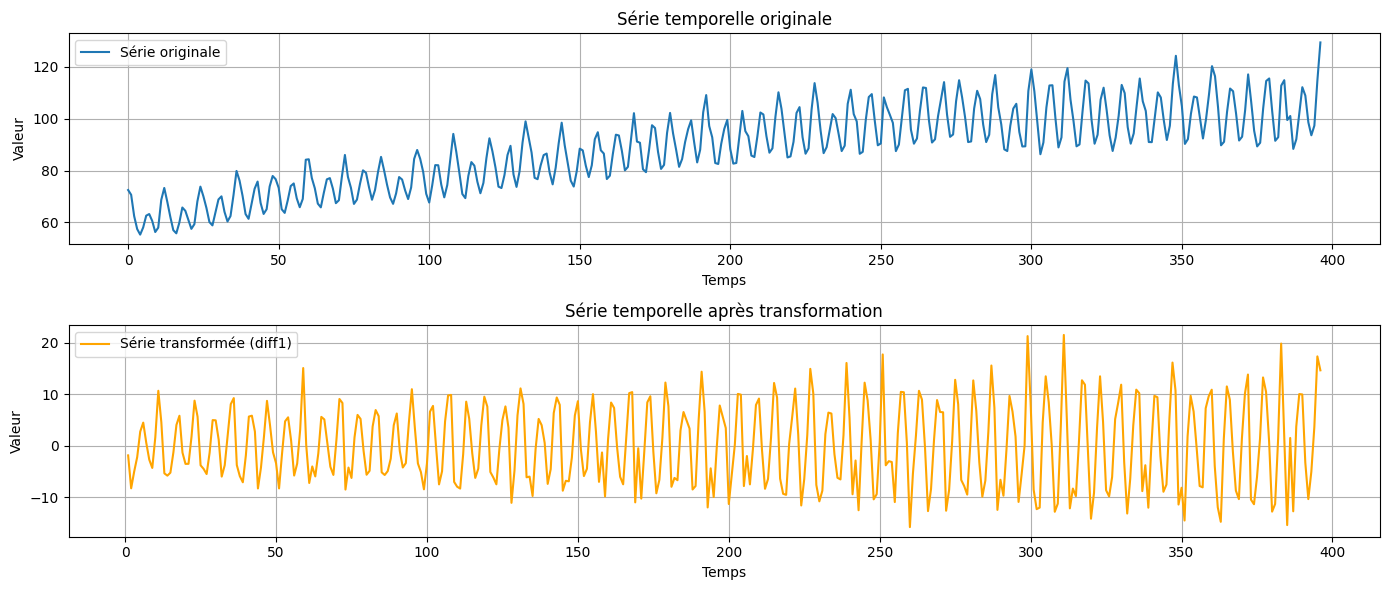

In [39]:
plt.figure(figsize=(14, 6))

# Série originale
plt.subplot(2, 1, 1)
plt.plot(s, label='Série originale')
plt.title('Série temporelle originale')
plt.xlabel('Temps')
plt.ylabel('Valeur')
plt.legend()
plt.grid(True)

# Série stationnaire (après transformation)
plt.subplot(2, 1, 2)
plt.plot(series_stationary, label=f'Série transformée ({applied})', color='orange')
plt.title('Série temporelle après transformation')
plt.xlabel('Temps')
plt.ylabel('Valeur')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
